# SELF DRIVING CAR

This code is to train car to drive itself.

The simulation is performed on a steering wheel (can be tested in the model script


Information & Resources
Credits: https://github.com/SullyChen/Autopilot-TensorFlow Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

NVidia dataset: 72 hrs of video => 726060*30 = 7,776,000 images Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/

Our Dataset: https://drive.google.com/drive/u/0/folders/1OidK8_42W1nJsehySZvxD1Fu3vfHW5xh
Size: 25 minutes = 256030 = 45,000 images ~ 2.3 GB

If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5 Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed

Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U 

Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c 

More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5



The AI can -- to a degree -- drive on streets that have solid, continuous objects on both sides. As a consequence, the AI is best at driving on highways, which usually have such walls or railings on both sides

## About Dataset

223GB of image frames and log data from 70 minutes of driving in Mountain View on two separate days, with one day being sunny, and the other overcast. Here is a sample of the log included in the dataset.
Note: Along with an image frame we also have latitude, longitude, gear, brake, throttle, steering angles and speed.

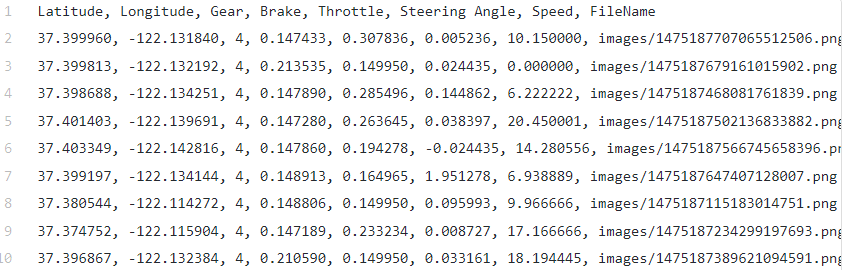

## Preprocessing

### Install Libraries

In [ ]:
!pip install scipy==1.2.2

     |████████████████████████████████| 24.8 MB 36 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
import cv2
import math
import scipy
import random
import warnings
import scipy.misc
import numpy as np
from scipy import pi
from subprocess import call
from itertools import islice
from datetime import datetime
from __future__ import division
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
warnings.filterwarnings("ignore", category=DeprecationWarning)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# import os
# os.chdir("/content/drive/MyDrive/Dataset")

### Unzipping Dataset

In [ ]:
!unzip -u "/content/drive/MyDrive/Dataset/driving_dataset.zip" -d "/content/drive/MyDrive/Dataset/dataset"

Archive:  /content/drive/MyDrive/Dataset/driving_dataset.zip
  inflating: /content/drive/MyDrive/Dataset/dataset/driving_dataset/.DS_Store  


### Loading Dataset and splitting to train and testing set

In [ ]:
image_data = []
angle_data = []

# Get number of images
num_images = 0

# Number of images for training
num_train_images = 0

# Number of images for testing
num_test_images = 0

def load_dataset():
    # Read data.txt
    with open("/content/drive/MyDrive/Dataset/dataset/driving_dataset/data.txt") as fp:
        for line in fp:
            image_data.append("/content/drive/MyDrive/Dataset/dataset/driving_dataset/" + line.split()[0])

            # the paper by Nvidia uses the inverse of the turning radius,
            # but steering wheel angle is proportional to the inverse of turning radius
            # so the steering wheel angle in radians is used as the output       
            angle_data.append(float(line.split()[1]) * scipy.pi / 180)

def split_dataset(train_split,test_split):
    # Split dataset to training and testing images
    # Using Angles variable as outr target variable
    images_to_train = image_data[:int(len(image_data) * train_split)]    
    angles_to_train = angle_data[:int(len(image_data) * train_split)]

    images_to_test = image_data[-int(len(image_data) * test_split):]
    angles_to_test = angle_data[-int(len(image_data) * test_split):]
    
    return images_to_train, angles_to_train, images_to_test, angles_to_test   
    

In [ ]:
# Load dataset
load_dataset()

# Split dataset
images_to_train, angles_to_train, images_to_test,angles_to_test = split_dataset(0.8,0.2)

num_images = len(image_data)
print("Total number of images: ",num_images)

num_train_images = len(images_to_train)
print("Total number of images for training: ",num_train_images)

num_test_images = len(images_to_test)
print("Total number of images for testing: ",num_test_images)

Total number of images:  45406
Total number of images for training:  36324
Total number of images for testing:  9081


### Simple EDA on Dataset

Plotting all the angles the steering wheel rotates within our dataset.


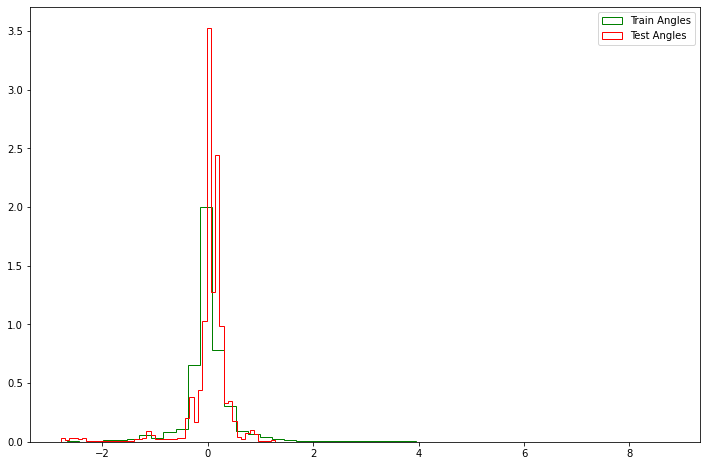

In [ ]:
# PDF of train and test angle values. 
plt.figure(figsize=(12,8))
plt.hist(angles_to_train, bins=50, density=1, color='green', histtype ='step',label="Train Angles")
plt.hist(angles_to_test, bins=50, density=1, color='red', histtype ='step',label="Test Angles")
plt.legend()
plt.show()

By observing above histogram plot, we can apply the simple Base Model

That is because most of the angle values are normally distributed and by simply applying Mean model we can find how well does the Mean model perform, instead of going through more complex models

## Modelling

### Model: Base line Model: y_test_pred = mean(y_train_i)

In [ ]:
# Model: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_angle = np.mean(angles_to_train)

print('Test_MSE(MEAN):%f' % np.mean(np.square(angles_to_test - train_mean_angle)))

Test_MSE(MEAN):0.191142


### Create End to End Model
Credits End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]


Model - Configuration Used:

- Train/Test Split: 80:20

- Batch Size : 500 images (Recommended 100 for better MSE)(But takes longer time to converge)

- Dropout : 0.80

- AdamOptimezer Value: 1e-4

- Activation Function: atan

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

**The model is a convolutional neural network, trained with a variant of Q-learning, whose input is raw pixels and whose output is a value function estimating future rewards.**

MODEL ARCHITECTURE:


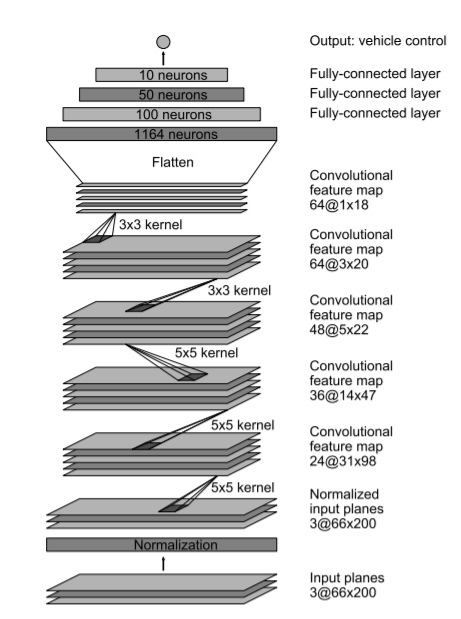

The first layer of the network performs image normalization. The normalizer is hard-coded and is not
adjusted in the learning process. Performing normalization in the network allows the normalization
scheme to be altered with the network architecture and to be accelerated via GPU processing.
The convolutional layers were designed to perform feature extraction and were chosen empirically
through a series of experiments that varied layer configurations. We use strided convolutions in the
first three convolutional layers with a 2×2 stride and a 5×5 kernel and a non-strided convolution
with a 3×3 kernel size in the last two convolutional layers.
We follow the five convolutional layers with three fully connected layers leading to an output control
value which is the inverse turning radius. The fully connected layers are designed to function as a
controller for steering, but we note that by training the system end-to-end, it is not possible to make
a clean break between which parts of the network function primarily as feature extractor and which
serve as controller.


The basic training method follows the standard reinforcement learning approach from the original Atari paper.


#### Why choose CNN?
Recent breakthroughs in computer vision and speech recognition have relied on efficiently training
deep neural networks on very large training sets. The most successful approaches are trained directly
from the raw inputs, using lightweight updates. By feeding
sufficient data into deep neural networks, it is often possible to learn better representations than
handcrafted features. These successes motivate my approach to reinforcement learning. My
goal is to connect a reinforcement learning algorithm to a deep neural network which operates
directly on RGB images and efficiently process training data by using stochastic gradient updates

In [ ]:
true_angle = tf.placeholder(tf.float32, shape=[None, 1],name="true_angle")
true_image = tf.placeholder(tf.float32, shape=[None, 66, 200, 3],name="true_image")

x_image = true_image

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])
h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])
h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])
h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])
h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32,name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])
h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)
h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])
h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)
h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

# atan activation function with scaling
predicted_angle = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2)
predicted_angle = tf.identity(predicted_angle,name="predicted_angle")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Model Training

General Idea Behind this Code

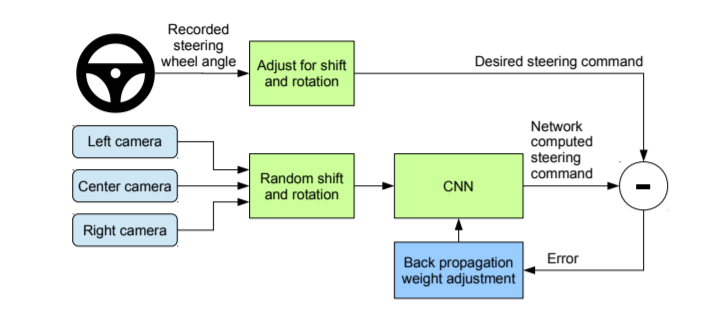

### Model with 'atan' activation function

In [ ]:
#points to the end of the last batch
train_batch_pointer = 0
test_batch_pointer = 0

# Utility Functions
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(images_to_train[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([angles_to_train[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadTestBatch(batch_size): 
    global test_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(images_to_test[(test_batch_pointer + i) % num_test_images])[-150:], [66, 200]) / 255.0)
        y_out.append([angles_to_test[(test_batch_pointer + i) % num_test_images]])
    test_batch_pointer += batch_size
    return x_out, y_out

In [ ]:
LOGDIR = '/content/drive/MyDrive/Dataset/dataset/models/atan/'

# Lets start the tensorflow session
sess = tf.InteractiveSession()

Train the weights of the network to minimize the mean squared error (**REWARD**) between the steering command output by the network and the command of either the human driver, or the adjusted steering
command for off-center and rotated images

In [ ]:
start = datetime.now()

print("Let the model learn itself...")
print()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(true_angle, predicted_angle))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)

# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver()

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 500

# train over the dataset about 30 times
previous_i = 0
previous_loss = 0
for epoch in range(epochs):
    for i in range(int(num_images/batch_size)):
        
        xs, ys = LoadTrainBatch(batch_size)
        
        train_step.run(feed_dict={true_image: xs, true_angle: ys, keep_prob: 0.80})
        if i % 10 == 0:
            xs, ys = LoadTestBatch(batch_size)
            loss_value = loss.eval(feed_dict={true_image:xs, true_angle: ys, keep_prob: 1.0})
            previous_loss = loss_value
            previous_i = i
            # print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

        # write logs at every iteration
        xx = 1.0
        # print(xs,ys,xx)
        summary = merged_summary_op.eval(feed_dict={true_image:xs, true_angle: ys, keep_prob: xx})
        summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)            
            checkpoint_path = os.path.join(LOGDIR, "model_atan.ckpt")
            filename = saver.save(sess, checkpoint_path)    
    print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + previous_i, previous_loss)) 
    print("Model saved in file: %s" % filename)
    print()

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

print("\nTime taken to train the model: ",datetime.now() - start)

## Future Work (Model 2 can be used for further testing, using linear activation method)
Due to limited resources, I left this as an option for the future once I have enough resources to train a model)

In [ ]:
true_image_ln = tf.placeholder(tf.float32, shape=[None, 66, 200, 3],name="true_image_ln")
true_angle_ln = tf.placeholder(tf.float32, shape=[None, 1],name="true_angle_ln")

x_image_ln = true_image_ln

#first convolutional layer
W_conv1_ln = weight_variable([5, 5, 3, 24])
b_conv1_ln = bias_variable([24])

h_conv1_ln = tf.nn.relu(conv2d(x_image_ln, W_conv1_ln, 2) + b_conv1_ln)

#second convolutional layer
W_conv2_ln = weight_variable([5, 5, 24, 36])
b_conv2_ln = bias_variable([36])

h_conv2_ln = tf.nn.relu(conv2d(h_conv1_ln, W_conv2_ln, 2) + b_conv2_ln)

#third convolutional layer
W_conv3_ln = weight_variable([5, 5, 36, 48])
b_conv3_ln = bias_variable([48])

h_conv3_ln = tf.nn.relu(conv2d(h_conv2_ln, W_conv3_ln, 2) + b_conv3_ln)

#fourth convolutional layer
W_conv4_ln = weight_variable([3, 3, 48, 64])
b_conv4_ln = bias_variable([64])

h_conv4_ln = tf.nn.relu(conv2d(h_conv3_ln, W_conv4_ln, 1) + b_conv4_ln)

#fifth convolutional layer
W_conv5_ln = weight_variable([3, 3, 64, 64])
b_conv5_ln = bias_variable([64])

h_conv5_ln = tf.nn.relu(conv2d(h_conv4_ln, W_conv5_ln, 1) + b_conv5_ln)

#FCL 1
W_fc1_ln = weight_variable([1152, 1164])
b_fc1_ln = bias_variable([1164])

h_conv5_flat_ln = tf.reshape(h_conv5_ln, [-1, 1152])
h_fc1_ln = tf.nn.relu(tf.matmul(h_conv5_flat_ln, W_fc1_ln) + b_fc1_ln)

keep_prob_ln = tf.placeholder(tf.float32,name="keep_prob_ln")
h_fc1_drop_ln = tf.nn.dropout(h_fc1_ln, keep_prob_ln)

#FCL 2
W_fc2_ln = weight_variable([1164, 100])
b_fc2_ln = bias_variable([100])

h_fc2_ln = tf.nn.relu(tf.matmul(h_fc1_drop_ln, W_fc2_ln) + b_fc2_ln)

h_fc2_drop_ln = tf.nn.dropout(h_fc2_ln, keep_prob_ln)

#FCL 3
W_fc3_ln = weight_variable([100, 50])
b_fc3_ln = bias_variable([50])

h_fc3_ln = tf.nn.relu(tf.matmul(h_fc2_drop_ln, W_fc3_ln) + b_fc3_ln)

h_fc3_drop_ln = tf.nn.dropout(h_fc3_ln, keep_prob_ln)

#FCL 3
W_fc4_ln = weight_variable([50, 10])
b_fc4_ln = bias_variable([10])

h_fc4_ln = tf.nn.relu(tf.matmul(h_fc3_drop_ln, W_fc4_ln) + b_fc4_ln)

h_fc4_drop_ln = tf.nn.dropout(h_fc4_ln, keep_prob_ln)

#Output
W_fc5_ln = weight_variable([10, 1])
b_fc5_ln = bias_variable([1])

# linear activation function
predicted_angle_ln = tf.matmul(h_fc4_drop_ln, W_fc5_ln) + b_fc5_ln
predicted_angle_ln = tf.identity(predicted_angle_ln,name="predicted_angle_ln")

In [ ]:
# Lets close the tensorflow session
sess.close()

In [ ]:
# Split dataset
images_to_train,angles_to_train,images_to_test,angles_to_test = split_dataset(0.7,0.3)

num_images = len(image_data)
print("Total number of images: ",num_images)

num_train_images = len(images_to_train)
print("Total number of images for training: ",num_train_images)

num_test_images = len(images_to_test)
print("Total number of images for testing: ",num_test_images)

# Reset the pointers
train_batch_pointer = 0
test_batch_pointer = 0

Total number of images:  45406
Total number of images for training:  31784
Total number of images for testing:  13621


In [ ]:
LOGDIR = '/content/drive/MyDrive/Dataset/dataset/models/linear/'

# Lets start the tensorflow session
sess = tf.InteractiveSession()

In [ ]:
start = datetime.now()

print("Let the model learn itself...")
print()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(true_angle_ln, predicted_angle_ln))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)

# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver()

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 1000

# train over the dataset about 30 times
previous_i = 0
previous_loss = 0
for epoch in range(epochs):
    for i in range(int(num_images/batch_size)):        
        xs, ys = LoadTrainBatch(batch_size)
        train_step.run(feed_dict={true_image_ln: xs, true_angle_ln: ys, keep_prob_ln: 0.50})
        print("PASS")
        if i % 10 == 0:            
            xs, ys = LoadTestBatch(batch_size)
            loss_value = loss.eval(feed_dict={true_image_ln:xs, true_angle_ln: ys, keep_prob_ln: 1.0})
            previous_loss = loss_value
            previous_i = i
            # print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

        # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={true_image_ln:xs, true_angle_ln: ys, keep_prob_ln: 1.0})
        summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)            
            checkpoint_path = os.path.join(LOGDIR, "model_linear.ckpt")
            filename = saver.save(sess, checkpoint_path)    
    print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + previous_i, previous_loss)) 
    print("Model saved in file: %s" % filename)
    print()

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

print("\nTime taken to train the model: ",datetime.now() - start)

In [ ]:
# Lets close the tensorflow session
sess.close()